<a name='1'></a>
## Import Packages and load data

In [1]:
### -*- coding: utf-8 -*-
"""
Created on Mon May 24 13:26:13 2021

@author: kjsanche

Description: 
A function to load the 5 minute granules from MODIS channel 1 
(0.65 microns) and the contrail mask for ML with a CNN.

To do:

-organize/markdown/comment code


Input:
Path   (string)

        
        
Output:
MODISCh1 (2D uint32)
MASK     (2D uint16)
"""
###########################################################################
#Check/understand if change from relu to sigmoid activation is necessary
#########################################################################

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import struct
import os
import glob
import random
#from format_input import *
from UNET_Functions import unet_model, summary
from Sat_contrail_read import Extract_RawDef, extract_img, extract_mask, extract_imglist, get_model_memory_usage
import tensorflow as tf
import sys
sys.path.append('/home/kjsanche/Desktop/Projects/loss')
from loss_function import *
from tensorflow.python.ops.metrics_impl import false_positives, false_negatives
import tensorflow.keras.metrics as tfm
import tensorflow_addons as tfa
from focal_loss import BinaryFocalLoss, SparseCategoricalFocalLoss

sys_details = tf.sysconfig.get_build_info()
print(sys_details)
cudnn_version = sys_details["cudnn_version"]
cuda_version = sys_details["cuda_version"]

print('cuda version: ', cuda_version)
print('cudNN version: ',cudnn_version)
print('TF version: ', tf.version.VERSION)




VALIDATION_SPLIT = 0.2
BATCH_SIZE = 2
EPOCHS = 300
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API
IMG_W=512
IMG_H=1024
N_CHANNELS = 8
TFrecord_path ='/home/kjsanche/Desktop/ExternalSSD/SatContrailData/TFrecords/'
Models_path ='/home/kjsanche/Desktop/ExternalSSD/SatContrailData/Models/'
#TFrecord_path = '/home/kjsanche/Desktop/Projects/Sat_Contrail_Unet/Unet/content/'
filenames=tf.io.gfile.glob([TFrecord_path + '*.tfrecords'])


random.shuffle(filenames)
split = int(len(filenames) * VALIDATION_SPLIT)

training_filenames = filenames[split:]
validation_filenames = filenames[:split]

validation_steps = len(validation_filenames) // BATCH_SIZE
steps_per_epoch = len(training_filenames)  // BATCH_SIZE

OrderedDict([('cpu_compiler', '/home/builder/ktietz/aggregate/tensorflow_recipes/ci_cpu/tensorflow-base_1614583966145/_build_env/bin/x86_64-conda_cos6-linux-gnu-gcc'), ('cuda_compute_capabilities', ['compute_35', 'compute_52', 'compute_60', 'compute_61', 'compute_70', 'compute_75']), ('cuda_version', '10.1'), ('cudnn_version', '7'), ('is_cuda_build', True), ('is_rocm_build', False)])
cuda version:  10.1
cudNN version:  7
TF version:  2.4.1


In [2]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
      'height': tf.io.FixedLenFeature([], tf.int64),
      'width':tf.io.FixedLenFeature([], tf.int64),
      'depth':tf.io.FixedLenFeature([], tf.int64),
      'raw_label':tf.io.FixedLenFeature([], tf.string),#tf.string = bytestring (not text string)
      'raw_image' : tf.io.FixedLenFeature([], tf.string),#tf.string = bytestring (not text string)
    }


    content = tf.io.parse_single_example(element, data)

    height = content['height']
    #height=1024
    width = content['width']
    #width=1024*2
    depth = content['depth']
    #depth=7
    raw_label = content['raw_label']
    raw_image = content['raw_image']


    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.float16)

    feature = tf.reshape(feature, shape=[height,width,depth])
    label = tf.io.parse_tensor(raw_label, out_type=tf.int8)
    label = tf.reshape(label, shape=[height,width])
    return (feature, label)

def get_batched_dataset(filenames):
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.Dataset.list_files(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.interleave(tf.data.TFRecordDataset, cycle_length=16, num_parallel_calls=AUTO)
    dataset = dataset.map(parse_tfr_element, num_parallel_calls=AUTO)

    dataset = dataset.cache() # This dataset fits in RAM
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) 
    dataset = dataset.prefetch(AUTO) #

    return dataset

def get_training_dataset(training_filenames):
    return get_batched_dataset(training_filenames)

def get_validation_dataset(training_filenames):
    return get_batched_dataset(validation_filenames)

def get_dataset_large(tfr_dir:str="/home/kjsanche/Desktop/Projects/Sat_Contrail_Unet/Unet/content/", pattern:str="*large_images.tfrecords"):
    files = glob.glob(tfr_dir+pattern, recursive=False)

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(parse_tfr_element)

    return dataset
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        #print(i)
        #print(display_list[i].shape)
        if i == 0:
            plt.imshow(np.float32(display_list[i][:,:,7]))#-display_list[i][:,:,1]))
        else:
            plt.imshow(np.float32(1*display_list[i]))
        plt.axis('off')
    plt.show()

The below code cell uses a lot of memory and therefore should only be used for testing and not be used during training.

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


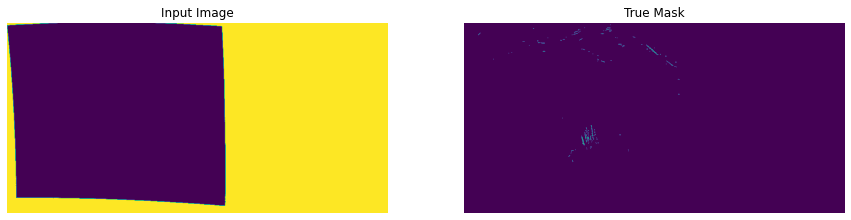

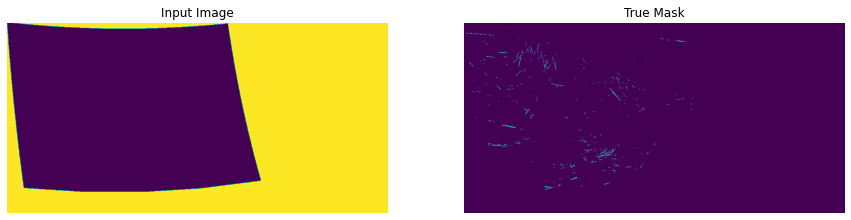

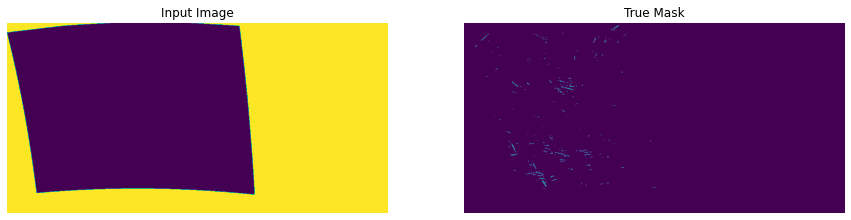

mem usage:  8914432


In [3]:
testdataset = get_dataset_large(tfr_dir = TFrecord_path, pattern = '*.tfrecords')
for image, mask in testdataset.take(3):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])
print('mem usage: ', tf.config.experimental.get_memory_usage("GPU:0"))

In [4]:
def TverskyLoss(targets, inputs, alpha=0.5, beta=0.5, smooth=1e-6):
        '''
        ... in the case of α=β=0.5 the Tversky index simplifies to be 
        the same as the Dice coefficient, which is also equal to the F1 
        score. With α=β=1, Equation 2 produces Tanimoto coefficient, and 
        setting α+β=1 produces the set of Fβ scores. Larger βs weigh 
        recall higher than precision (by placing more emphasis on false negatives).
        '''
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return 1 - Tversky
    

def FocalTverskyLoss(targets, inputs, alpha=0.5, beta=0.5, gamma=1, smooth=1e-6):
        targets = tf.cast(targets,tf.float32)
        #flatten label and prediction tensors
        inputs = K.flatten(inputs)
        targets = K.flatten(targets)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((inputs * targets))
        FP = K.sum(((1-targets) * inputs))
        FN = K.sum((targets * (1-inputs)))
               
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        FocalTversky = K.pow((1 - Tversky), gamma)
        
        return FocalTversky

In [5]:

#gamma>0 reduces the relative loss for well-classified examples 
#alpha is a weighted term whose value is α for positive(foreground) alpha = 1 does nothing. alpha = 0.25 is best
#class and 1-α for negative(background) class.

unet = unet_model((IMG_W, IMG_H, N_CHANNELS),n_filters=32,n_classes=1)
#loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#loss=tfa.losses.SigmoidFocalCrossEntropy(),
#loss=[BinaryFocalLoss(gamma=2,from_logits=True)],

#Larger βs weigh recall higher than precision (by placing more emphasis on false negatives)
#loss=TverskyLoss(targets, inputs, alpha=0.5, beta=0.5, smooth=1e-6)
#loss=FocalTverskyLoss(targets, inputs, alpha=0.5, beta=0.5, gamma=1, smooth=1e-6)
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
              loss=[FocalTverskyLoss],
              metrics=[tfm.Precision(), tfm.Recall(), tfm.FalseNegatives(), tfm.FalsePositives(), tfm.TruePositives(), tfm.TrueNegatives(), 'binary_accuracy'])
#unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
#              loss=[SparseCategoricalFocalLoss(gamma=2,class_weight  = 1,from_logits=True)],
#              metrics=['accuracy'])
unet.summary(line_length = 130)
print('mem usage: ', tf.config.experimental.get_memory_usage("GPU:0"))

Model: "model"
__________________________________________________________________________________________________________________________________
Layer (type)                              Output Shape                 Param #         Connected to                               
input_1 (InputLayer)                      [(None, 512, 1024, 8)]       0                                                          
__________________________________________________________________________________________________________________________________
conv2d (Conv2D)                           (None, 512, 1024, 32)        2336            input_1[0][0]                              
__________________________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                         (None, 512, 1024, 32)        9248            conv2d[0][0]                               
____________________________________________________________________

In [ ]:
print(get_model_memory_usage(BATCH_SIZE, unet))


training_data = get_training_dataset(training_filenames)
validation_data = get_training_dataset(validation_filenames)
print(training_data)
model_history = unet.fit(training_data, validation_data=validation_data, validation_steps=validation_steps, steps_per_epoch=steps_per_epoch, epochs=EPOCHS)



1.938
<PrefetchDataset shapes: ((2, None, None, None), (2, None, None)), types: (tf.float16, tf.int8)>
Epoch 1/300
240/240 [==============================] - 231s 677ms/step - loss: 0.9967 - precision: 0.0017 - recall: 0.8918 - false_negatives: 11290.7635 - false_positives: 112435587.1079 - true_positives: 169742.7967 - true_negatives: 14256719.7012 - binary_accuracy: 0.1929 - val_loss: 0.9969 - val_precision: 0.0015 - val_recall: 1.0000 - val_false_negatives: 0.0000e+00 - val_false_positives: 61770808.0000 - val_true_positives: 95171.0000 - val_true_negatives: 0.0000e+00 - val_binary_accuracy: 0.0015
Epoch 2/300
240/240 [==============================] - 162s 674ms/step - loss: 0.9973 - precision: 0.0014 - recall: 1.0000 - false_negatives: 0.0000e+00 - false_positives: 126692228.7469 - true_positives: 181116.8299 - true_negatives: 0.0000e+00 - binary_accuracy: 0.0014 - val_loss: 0.9973 - val_precision: 0.0013 - val_recall: 1.0000 - val_false_negatives: 0.0000e+00 - val_false_positives

In [ ]:
#unet.save_weights(Models_path+'model')
#unet = tf.keras.models.load_model(Models_path+'model')

In [ ]:

fig, axs = plt.subplots(2,2, figsize=(15,15))

axs[0,0].plot(model_history.history['binary_accuracy'])
axs[0,0].plot(model_history.history['val_binary_accuracy'])
axs[0,0].set_title('model accuracy')
axs[0,0].set_ylabel('accuracy')

#axs[0].legend(['train', 'val'], loc='upper left')
#axs[0].show()

axs[1,0].plot(model_history.history['loss'])
axs[1,0].plot(model_history.history['val_loss'])
axs[1,0].set_title('model loss')
axs[1,0].set_ylabel('loss')

axs[1,0].legend(['train', 'val'], loc='upper right')



F1 = 2*np.divide(np.multiply(model_history.history['precision'],model_history.history['recall']), np.add(model_history.history['precision'], model_history.history['recall']))
F1_val = 2*np.divide(np.multiply(model_history.history['val_precision'],model_history.history['val_recall']), np.add(model_history.history['val_precision'], model_history.history['val_recall']))
FP = model_history.history['false_positives']
TP = model_history.history['true_positives']
FN = model_history.history['false_negatives']
TN = model_history.history['true_negatives']
MCC = np.subtract(np.multiply(TP,TN),np.multiply(FP,FN))/np.sqrt(np.multiply(np.multiply(np.add(TP,FP),np.add(TP,FN)), np.multiply(np.add(TN,FP),np.add(TN,FN))))
FP = model_history.history['val_false_positives']
TP = model_history.history['val_true_positives']
FN = model_history.history['val_false_negatives']
TN = model_history.history['val_true_negatives']
MCC_val = np.subtract(np.multiply(TP,TN),np.multiply(FP,FN))/np.sqrt(np.multiply(np.multiply(np.add(TP,FP),np.add(TP,FN)), np.multiply(np.add(TN,FP),np.add(TN,FN))))

axs[0,1].plot(F1)
axs[0,1].plot(F1_val)
axs[0,1].set_title('model F1 score')
axs[0,1].set_ylabel('F1')
axs[0,1].set_xlabel('epoch')

axs[1,1].plot(MCC)
axs[1,1].plot(MCC_val)
axs[1,1].set_title('model MCC')
axs[1,1].set_ylabel('MCC')
axs[1,1].set_xlabel('epoch')


plt.savefig(Models_path+ 'Model2.png')

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    #print(pred_mask.shape)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image[tf.newaxis,:,:,:])
            print(mask)
            test=  np.squeeze(pred_mask)
            print(test.shape)
            #display([image, mask, test])
            display([image, mask, create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])


In [ ]:
testdataset = get_dataset_large(tfr_dir = TFrecord_path, pattern = '*.tfrecords')
print(testdataset)
show_predictions(testdataset, 10)

#####################change display to show 11microns -12 microns or whatever it should be

In [ ]:
pr_mask = unet.predict(image[tf.newaxis,:,:,:])
plt.imshow(
    pr_mask[0]
)
plt.colorbar()